### Building a full fledged lasso model.

Here, we focus on building a full fledged lasso model. Here we go !

In [1]:
# Scratch
import pandas as pd
import sys
orig_train_data = pd.read_csv('../../input/train.csv')

In [2]:
sys.path.append('../../common_routines/')
import numpy as np
from relevant_functions import\
    evaluate_model_score_given_predictions,\
    fit_pipeline_and_evaluate_on_validation_set,\
    fit_pipeline_and_cross_validate, \
    fit_pipeline_and_return_cross_validation_scores, \
    fit_pipeline_and_make_predictions_on_test_set

In [3]:
orig_train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
len(orig_train_data.columns)

81

In [5]:
orig_train_data['Functional'].unique()

array(['Typ', 'Min1', 'Maj1', 'Min2', 'Mod', 'Maj2', 'Sev'], dtype=object)

### Plan

1. For every column in original training data, we should have one of the following transforms :

    (a) Does nothing
    
    (b) Does log transform
    
    (c) Does one hot encoding
    
    (d) Handles null values (say for MasVnrArea)
    
    
These transforms will create variables that are passed on to lasso method using modified dataframe. 

One question is whether we have linearly dependent columns as inputs to lasso. I beleive that it should be fine, as it would simply finetune the algorithm. One must however check whether there are dependent predictors in the final model.

In [6]:
def get_rel_X_cols(X_columns, X_column_transform_map, input_df=None, validation_df=None):
    rel_X_cols = list()
    for col in X_columns:
        if col in X_column_transform_map.keys():
            rel_cols = X_column_transform_map.get(col)(col , input_df, validation_df)
        else:
            rel_cols = [col]
        for elem in rel_cols:
            rel_X_cols.append(elem)
    return rel_X_cols

In [7]:
train_data_one_hot = pd.read_csv('../../cleaned_input/train_data_one_hot.csv')
validation_data_one_hot = pd.read_csv('../../cleaned_input/validation_data_one_hot.to_csv')
test_data_one_hot =pd.read_csv('../../cleaned_input/test_data_one_hot.csv')

In [8]:
train_data_one_hot.columns.values

array(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea',
       'GarageCars', 'GarageYrBlt', 'GarageYrBlt_not_missing',
       'GarageYrBlt_times_not_missing', 'GrLivArea', 'HalfBath', 'Id',
       'KitchenAbvGr', 'Log1stFlrSF', 'Log2ndFlrSF', 'Log3SsnPorch',
       'LogBsmtFinSF1', 'LogBsmtFinSF2', 'LogBsmtUnfSF',
       'LogEnclosedPorch', 'LogGarageArea', 'LogGrLivArea', 'LogLotArea',
       'LogLowQualFinSF', 'LogMasVnrArea_times_not_missing', 'LogMiscVal',
       'LogOpenPorchSF', 'LogPoolArea', 'LogSalePrice', 'LogScreenPorch',
       'LogTotalBsmtSF', 'LogWoodDeckSF', 'LotArea', 'LowQualFinSF',
       'MasVnrArea', 'MasVnrArea_not_missing',
       'MasVnrArea_times_not_missing', 'MiscVal', 'OpenPorchSF',
       'OverallCond', 'OverallQual', 'PoolArea', 'SalePrice',
       'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF',
   

In [9]:
def get_nothing(column, input_df=None, validation_df=None):
    return []

def get_column_itself(column, input_df=None, validation_df=None):
    return [column]

def get_log_transform(column, input_df=None, validation_df=None):
    return ['Log' + column]
    
def get_one_hot_encoded_transformation(column, input_df=None, validation_df=None):
    
    rel_cols = [col for col in input_df.columns if column + '_' in col and column + '_Val' not in col]
    return rel_cols

def get_null_value_handling_with_log_transform(column, input_df=None, validation_df=None):
    rel_cols = ['Log' + column + '_times_not_missing', column + '_not_missing']
    return rel_cols

def get_null_value_handling_with_no_transform(column, input_df=None, validation_df=None):
    rel_cols = [column + '_times_not_missing', column + '_not_missing']
    return rel_cols

'GarageFinish',
'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition',

In [10]:
rel_list  = ['GarageFinish', 'GarageCars', 'GarageArea']
for val in rel_list:
    print('           \'' + val + '\',')
for val in rel_list:
    print('                        \'' + val + '\'' + ' : get_one_hot_encoded_transformation,')

           'GarageFinish',
           'GarageCars',
           'GarageArea',
                        'GarageFinish' : get_one_hot_encoded_transformation,
                        'GarageCars' : get_one_hot_encoded_transformation,
                        'GarageArea' : get_one_hot_encoded_transformation,


In [11]:
rel_cols= ['Id',
           'MSSubClass',
           'MSZoning',
           'LotFrontage',
           'LotArea',
           'Street',
           'LotShape',
           'LandContour',               
           'Utilities',                              
           'LotConfig',                                             
           'LandSlope',                                                            
           'Neighborhood',        
           'Condition1', 
           'Condition2', 
           'BldgType',
           'HouseStyle',
           'OverallQual',
           'OverallCond',
           'YearBuilt', 
           'YearRemodAdd',
           'RoofStyle', 
           'RoofMatl', 
           'Exterior1st',  
           'Exterior2nd', 
           'MasVnrType', 
           'MasVnrArea',
           'ExterQual',
           'ExterCond',
           'Foundation',
           'BsmtQual',
           'BsmtCond',
           'BsmtExposure',
           'BsmtFinType1',
           'BsmtFinSF1',
           'BsmtFinType2',
           'BsmtUnfSF', 
           'TotalBsmtSF',
           'Heating',
           'HeatingQC',
           'CentralAir',
           'Electrical',
           '1stFlrSF',
           '2ndFlrSF',
           'LowQualFinSF',
           'GrLivArea',
           'BsmtFullBath', 
           'BsmtHalfBath', 
           'FullBath',
           'HalfBath', 
           'BedroomAbvGr', 
           'KitchenAbvGr',
           'KitchenQual',
           'TotRmsAbvGrd',
           'Functional',
           'Fireplaces',
           'FireplaceQu',
           'GarageType', 
           'GarageYrBlt',
           'GarageFinish', 
           'GarageCars', 
           'GarageArea', 
           'GarageQual',
           'GarageCond', 
           'PavedDrive', 
           'WoodDeckSF', 
           'OpenPorchSF',
           'EnclosedPorch',
           '3SsnPorch', 
           'ScreenPorch', 
           'PoolArea', 
           'PoolQC',
           'Fence', 
           'MiscFeature', 
           'MiscVal', 
           'MoSold', 
           'YrSold', 
           'SaleType',
           'SaleCondition',
           'Alley']

In [12]:
relevant_transform_map={'Id' : get_nothing,
                        'MSSubClass' : get_one_hot_encoded_transformation,
                        'MSZoning' : get_one_hot_encoded_transformation,
                        'LotFrontage': get_nothing,
                        'LotArea': get_log_transform,
                        'Street' : get_one_hot_encoded_transformation,                            
                        'LotShape' : get_one_hot_encoded_transformation,                                                     
                        'LandContour' : get_one_hot_encoded_transformation,                                                     
                        'Utilities' : get_one_hot_encoded_transformation,                                                                                 
                        'LotConfig' : get_one_hot_encoded_transformation,                                                                                                             
                        'LandSlope' : get_one_hot_encoded_transformation,                                                                                                                                         
                        'Neighborhood' : get_one_hot_encoded_transformation,                                                                                                                                                                     
                        'Condition1' : get_one_hot_encoded_transformation,                                                                                                                                                                                                 
                        'Condition2' : get_one_hot_encoded_transformation,                                                                                                                                                                                                 
                        'BldgType' : get_one_hot_encoded_transformation,                                                                                                                                                                                                 
                        'HouseStyle' : get_one_hot_encoded_transformation,  
                        'OverallQual' : get_column_itself,  
                        'OverallCond' : get_column_itself,                              
                        'YearBuilt' : get_column_itself,  
                        'YearRemodAdd' : get_column_itself,                              
                        'RoofStyle' : get_one_hot_encoded_transformation,                                                                                                                                                                     
                        'RoofMatl' : get_one_hot_encoded_transformation,                                                                                                                                                                                                 
                        'Exterior1st' : get_one_hot_encoded_transformation,                                                                                                                                                                                                 
                        'Exterior2nd' : get_one_hot_encoded_transformation,                                                                                                                                                                                                 
                        'MasVnrType' : get_one_hot_encoded_transformation,  
                        'MasVnrArea' : get_null_value_handling_with_log_transform,
                        'ExterQual' : get_one_hot_encoded_transformation,
                        'ExterCond' : get_one_hot_encoded_transformation,
                        'Foundation' : get_one_hot_encoded_transformation,
                        'BsmtQual' : get_one_hot_encoded_transformation,
                        'BsmtCond' : get_one_hot_encoded_transformation,
                        'BsmtExposure' : get_one_hot_encoded_transformation,
                        'BsmtFinType1' : get_one_hot_encoded_transformation,   
                        'BsmtFinSF1' : get_log_transform,
                        'BsmtFinType2' : get_one_hot_encoded_transformation,
                        'BsmtUnfSF' : get_column_itself, 
                        'TotalBsmtSF' : get_column_itself,
                        'Heating' : get_one_hot_encoded_transformation,
                        'HeatingQC' : get_one_hot_encoded_transformation,
                        'CentralAir' : get_one_hot_encoded_transformation,
                        'Electrical' : get_one_hot_encoded_transformation,  
                        '1stFlrSF' : get_log_transform,
                        '2ndFlrSF' : get_log_transform,
                        'LowQualFinSF' : get_log_transform,
                        'GrLivArea' : get_log_transform,
                        'BsmtFullBath' : get_column_itself, 
                        'BsmtHalfBath':get_column_itself, 
                        'FullBath' : get_column_itself,
                        'HalfBath' : get_column_itself, 
                        'BedroomAbvGr' : get_column_itself, 
                        'KitchenAbvGr' :get_column_itself,
                        'KitchenQual' : get_one_hot_encoded_transformation,
                        'TotRmsAbvGrd' : get_column_itself,
                        'Functional' : get_one_hot_encoded_transformation, 
                        'Fireplaces' : get_column_itself,
                        'FireplaceQu' : get_one_hot_encoded_transformation,
                        'GarageType' : get_one_hot_encoded_transformation,
                        'GarageYrBlt' : get_null_value_handling_with_no_transform,
                        'GarageFinish' : get_one_hot_encoded_transformation,
                        'GarageCars': get_column_itself,
                        'GarageArea' : get_log_transform,
                        'GarageQual' : get_one_hot_encoded_transformation,
                        'GarageCond' : get_one_hot_encoded_transformation,
                        'PavedDrive' : get_one_hot_encoded_transformation,
                        'WoodDeckSF' : get_log_transform,
                        'OpenPorchSF' : get_log_transform,
                        'EnclosedPorch' : get_log_transform,
                        '3SsnPorch' : get_log_transform,
                        'ScreenPorch' : get_log_transform, 
                        'PoolArea' : get_log_transform, 
                        'PoolQC' : get_one_hot_encoded_transformation,
                        'Fence' : get_one_hot_encoded_transformation,
                        'MiscFeature' : get_one_hot_encoded_transformation,
                        'MiscVal' : get_log_transform, 
                        'MoSold' : get_one_hot_encoded_transformation, 
                        'YrSold' : get_one_hot_encoded_transformation, 
                        'SaleType' : get_one_hot_encoded_transformation,
                        'SaleCondition' : get_one_hot_encoded_transformation,
                        'Alley' : get_nothing}


In [13]:
rel_X_cols = get_rel_X_cols(
    X_columns=rel_cols,
    X_column_transform_map=relevant_transform_map,
    input_df=train_data_one_hot,
    validation_df=validation_data_one_hot)


Now, that we are going to employ the lasso, we have to make sure that the predictors are standardized first. Hence we encapsulate , everything to a pipeline.

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

In [15]:
def get_all_imputing_all_normalizing_pipe(alpha=2000):
    my_pipe = Pipeline([('scaling', StandardScaler()),
                        ('model', linear_model.Lasso(alpha=alpha))]
                      )
    return my_pipe

Let us a build a lasso model and see how it looks on the validaiton set.

In [16]:
(my_pipe, validaiton_score) = \
    fit_pipeline_and_evaluate_on_validation_set(get_all_imputing_all_normalizing_pipe(), 
                                                train_data_one_hot, 
                                                validation_data_one_hot, rel_X_cols)

/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [17]:
my_pipe

Pipeline(memory=None,
     steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', Lasso(alpha=2000, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [18]:
np.sum(my_pipe.named_steps['model'].coef_ !=0)

0

In [19]:
validaiton_score

0.3839530153620444

#### What went wrong here ?

The problem is that the penalty term was too large, resulting in extreme shrinkage of predictors, resulting in all of them boiling down to 0. 

Let us reduce the penalty term and see how it goes.

In [20]:
(my_pipe, validaiton_score) = \
    fit_pipeline_and_evaluate_on_validation_set(get_all_imputing_all_normalizing_pipe(alpha=0.01), 
                                                train_data_one_hot, 
                                                validation_data_one_hot, rel_X_cols)
print(np.sum(my_pipe.named_steps['model'].coef_ !=0))    
print(validaiton_score)

53
0.14489334115758548


/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


#### Going to cross validation
The results look much better. Now the question comes as to whether we can use cross validation or not.

We can definitely use cross validaiton, but because of the presence of a lot of categorical variables, this might result in lots of predictors being completely zeros during some rounds of cross validation, which could cause the model build to blow up. Before we embark on cross validation , we need to make sure that this does not happen.

Let us add some duplicate columns and see how lasso handles the same.

In [21]:
sub_cols= ['Id',
           'MSSubClass',
           'MSZoning',
           'LotArea',
           'LotArea',
           'LotArea']


In [22]:
def build_and_print_lasso_model_stats(sub_cols=rel_cols, 
                                      alpha =0.1,
                                      relevant_transform_map=relevant_transform_map, 
                                      train_data_one_hot=train_data_one_hot,
                                      validation_data_one_hot=validation_data_one_hot):
    rel_X_cols = get_rel_X_cols(
        X_columns=sub_cols,
        X_column_transform_map=relevant_transform_map,
        input_df=train_data_one_hot,
        validation_df=validation_data_one_hot)

    (my_pipe, validaiton_score) = \
        fit_pipeline_and_evaluate_on_validation_set(get_all_imputing_all_normalizing_pipe(alpha=alpha), 
                                                    train_data_one_hot, 
                                                    validation_data_one_hot, rel_X_cols)
    print_lasso_pipeline_stats(my_pipe, detailed_stats=True)
    print("Accuracy on validation data             : ", validaiton_score)


In [23]:
def print_lasso_pipeline_stats(my_pipe, detailed_stats=False):
    print("Number of predictors in the final model : ", np.sum(my_pipe.named_steps['model'].coef_ !=0))    
    if detailed_stats:
        print("\n========== Boolean array of chosen predictors ======== \n\n ", (my_pipe.named_steps['model'].coef_ !=0))  
        print("========================================================\n")
        print("\n========== Predictor coefficients ====================\n\n ", (my_pipe.named_steps['model'].coef_))    
        print("========================================================\n")
    

In [24]:
build_and_print_lasso_model_stats(sub_cols)

Number of predictors in the final model :  5

========== Boolean array of chosen predictors ======== 

  [False False False False False False  True False False False  True False
 False False False False False False False False  True  True False  True]


========== Predictor coefficients ====================

  [ 0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -1.55442263e-02 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  5.39323448e-02 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -1.46370516e-02  4.49883904e-02  0.00000000e+00  3.89338485e-17]

Accuracy on validation data             :  0.34653340680656985


/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


We see that though the resultant model may perform well, numerical issues can result in some of the duplicate predictors also getting a non zero coefficient(a very small one) and hence resulting in inflation in number of predictors.

### Zero predictors.

Now, we come to the case when one of the predictor is completely zero (this is more relevant in the case of cross valdiaiton procedure due to the presence of one hot encoded categorical variables).

In [25]:
train_data_one_hot['Dummy'] = 0.0
validation_data_one_hot['Dummy'] = 0.0

In [26]:
sub_cols= ['Id',
           'MSSubClass',
           'MSZoning',
           'LotArea',
           'Dummy']


In [27]:
build_and_print_lasso_model_stats(sub_cols)

Number of predictors in the final model :  4

========== Boolean array of chosen predictors ======== 

  [False False False False False False  True False False False  True False
 False False False False False False False False  True  True False]


========== Predictor coefficients ====================

  [ 0.          0.         -0.         -0.         -0.          0.
 -0.01554423 -0.         -0.         -0.          0.05393234 -0.
  0.         -0.         -0.         -0.         -0.          0.
 -0.          0.         -0.01463705  0.04498839  0.        ]

Accuracy on validation data             :  0.3465334068065698


/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



That looks encouraging. Let us just see what happens if we add another column with zero entries.

In [28]:
train_data_one_hot['Dummy'] = 0
validation_data_one_hot['Dummy'] = 0
train_data_one_hot['Dummy2'] = 0
validation_data_one_hot['Dummy2'] = 0

In [29]:
sub_cols= ['Id',
           'MSSubClass',
           'MSZoning',
           'LotArea',
           'Dummy',
           'Dummy2']


In [30]:
build_and_print_lasso_model_stats(sub_cols)

Number of predictors in the final model :  4

========== Boolean array of chosen predictors ======== 

  [False False False False False False  True False False False  True False
 False False False False False False False False  True  True False False]


========== Predictor coefficients ====================

  [ 0.          0.         -0.         -0.         -0.          0.
 -0.01554423 -0.         -0.         -0.          0.05393234 -0.
  0.         -0.         -0.         -0.         -0.          0.
 -0.          0.         -0.01463705  0.04498839  0.          0.        ]

Accuracy on validation data             :  0.3465334068065698


/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Okay it looks like lasso handles this well, giving us a green light to embark on cross valid
ation.

In [31]:
train_data_one_hot.drop(columns=['Dummy', 'Dummy2'], inplace=True)
validation_data_one_hot.drop(columns=['Dummy', 'Dummy2'], inplace=True)

In [32]:
# Let us combine the dataframes together to increase amount of data at our disposal.
train_validation_data_one_hot = pd.concat([train_data_one_hot, validation_data_one_hot])

In [33]:
rel_X_cols

['MSSubClass_120',
 'MSSubClass_150',
 'MSSubClass_160',
 'MSSubClass_180',
 'MSSubClass_190',
 'MSSubClass_20',
 'MSSubClass_30',
 'MSSubClass_40',
 'MSSubClass_45',
 'MSSubClass_50',
 'MSSubClass_60',
 'MSSubClass_70',
 'MSSubClass_75',
 'MSSubClass_80',
 'MSSubClass_85',
 'MSSubClass_90',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'LogLotArea',
 'Street_Grvl',
 'Street_Pave',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_Bnk',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'Utilities_AllPub',
 'Utilities_NoSeWa',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'LandSlope_Gtl',
 'LandSlope_Mod',
 'LandSlope_Sev',
 'Neighborhood_Blmngtn',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neigh

#### Alpha : 0.1

In [34]:
(my_pipe, cross_validation_scores) =  fit_pipeline_and_return_cross_validation_scores(
    get_all_imputing_all_normalizing_pipe(alpha=0.1),   
    train_validation_data_one_hot,
    X_columns=rel_X_cols)

/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python

In [35]:
cross_validation_scores

array([0.20840778, 0.23262367, 0.22763913, 0.19911074, 0.2109533 ])

#### Alpha : 0.05

In [36]:
(my_pipe, cross_validation_scores) =  fit_pipeline_and_return_cross_validation_scores(
    get_all_imputing_all_normalizing_pipe(alpha=0.05), 
    train_validation_data_one_hot,
    X_columns=rel_X_cols)
print(cross_validation_scores.mean())
print(cross_validation_scores)
print_lasso_pipeline_stats(my_pipe)

/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python

0.17365289674207793
[0.1630993  0.18239288 0.18105086 0.15956896 0.1821525 ]
Number of predictors in the final model :  11


/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


#### Alpha : 0.01

In [37]:
(my_pipe, cross_validation_scores) =  fit_pipeline_and_return_cross_validation_scores(
    get_all_imputing_all_normalizing_pipe(alpha=0.01), 
    train_validation_data_one_hot,
    X_columns=rel_X_cols)
print(cross_validation_scores.mean())
print(cross_validation_scores.std())
print(cross_validation_scores)
print_lasso_pipeline_stats(my_pipe)

/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python

0.13005883179600125
0.018103106867156795
[0.10565665 0.13987823 0.13844707 0.11245373 0.15385848]
Number of predictors in the final model :  49


/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


#### Alpha : 0.005

In [38]:
(my_pipe, cross_validation_scores) =  fit_pipeline_and_return_cross_validation_scores(
    get_all_imputing_all_normalizing_pipe(alpha=0.005), 
    train_validation_data_one_hot,
    X_columns=rel_X_cols)
print(cross_validation_scores.mean())
print(cross_validation_scores.std())
print(cross_validation_scores)
print_lasso_pipeline_stats(my_pipe)

/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python

0.12653827091920639
0.018182177031224295
[0.10141292 0.13500218 0.13681381 0.1094327  0.15002975]
Number of predictors in the final model :  91


/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


#### Alpha : 0.001

In [39]:
(my_pipe, cross_validation_scores) =  fit_pipeline_and_return_cross_validation_scores(
    get_all_imputing_all_normalizing_pipe(alpha=0.001), 
    train_validation_data_one_hot,
    X_columns=rel_X_cols)
print(cross_validation_scores.mean())
print(cross_validation_scores.std())
print(cross_validation_scores)
print_lasso_pipeline_stats(my_pipe)

/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python

0.13127309724925343
0.019990430593152985
[0.10607825 0.13833795 0.14549448 0.10973796 0.15671684]
Number of predictors in the final model :  208


/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


#### Alpha : 0.0005

In [40]:
(my_pipe, cross_validation_scores) =  fit_pipeline_and_return_cross_validation_scores(
    get_all_imputing_all_normalizing_pipe(alpha=0.0005), 
    train_validation_data_one_hot,
    X_columns=rel_X_cols)
print(cross_validation_scores.mean())
print(cross_validation_scores.std())
print(cross_validation_scores)
print_lasso_pipeline_stats(my_pipe)

/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python

0.13399446342622526
0.020730973878268222
[0.10887034 0.14096242 0.1495903  0.1105503  0.15999895]
Number of predictors in the final model :  236


/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


#### Find optimal alpha.

It looks like the optimal alpha value is around 0.005. Let us verify this by testing on some values around this range.

In [41]:
alpha_values_to_be_tested = np.arange(0.001, 0.010, 0.001)

In [42]:
cross_val_means = np.zeros(len(alpha_values_to_be_tested))
num_of_dimensons = np.zeros(len(alpha_values_to_be_tested))

In [43]:
cur_index =0 
for alpha_val in alpha_values_to_be_tested:
    print(alpha_val)
    (my_pipe, cross_validation_scores) =  fit_pipeline_and_return_cross_validation_scores(
        get_all_imputing_all_normalizing_pipe(alpha=alpha_val), 
        train_validation_data_one_hot,
        X_columns=rel_X_cols)
    cross_val_means[cur_index] = cross_validation_scores.mean()
    num_of_dimensons[cur_index] = np.sum(my_pipe.named_steps['model'].coef_ !=0)
    cur_index += 1
    

/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


0.001


/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-pa

0.002


/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-package

0.003


/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/p

0.004


/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-pa

0.005


/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-pa

0.006


/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-pa

0.007


/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-pa

0.008


/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-pa

0.009000000000000001


/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/p

In [44]:
cross_val_means

array([0.1312731 , 0.12821027, 0.12659153, 0.12617111, 0.12653827,
       0.12691304, 0.12745116, 0.12814534, 0.1290361 ])

In [45]:
import matplotlib.pyplot as plt
FIGURE_LENGTH = 16
FIGURE_BREADTH = 9


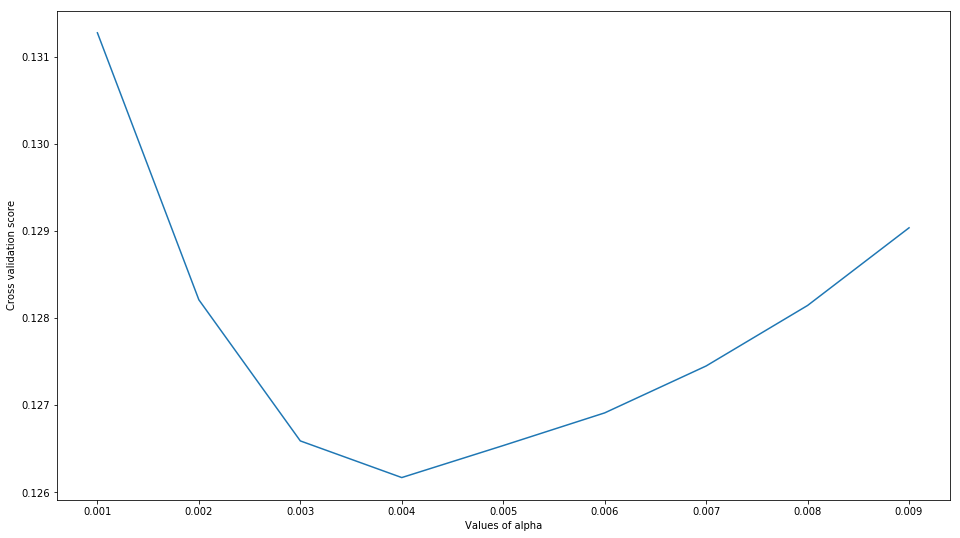

In [46]:
fig = plt.figure(figsize=(FIGURE_LENGTH, FIGURE_BREADTH))

ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel('Values of alpha')
ax1.set_ylabel('Cross validation score')
ax1.plot(alpha_values_to_be_tested, cross_val_means)

Let us check out the dimensionality of each of these values of alpha as well.

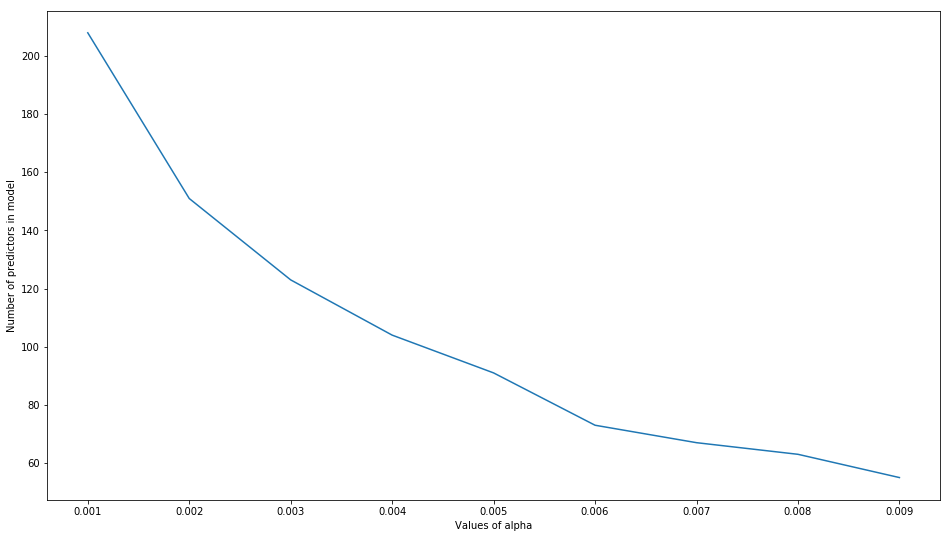

In [47]:
fig = plt.figure(figsize=(FIGURE_LENGTH, FIGURE_BREADTH))

ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel('Values of alpha')
ax1.set_ylabel('Number of predictors in model')
ax1.plot(alpha_values_to_be_tested, num_of_dimensons)

In [48]:
num_of_dimensons

array([208., 151., 123., 104.,  91.,  73.,  67.,  63.,  55.])

#### Let us check out value of alpha = 0.004


In [49]:
(my_pipe, cross_validation_scores) =  fit_pipeline_and_return_cross_validation_scores(
    get_all_imputing_all_normalizing_pipe(alpha=0.004), 
    train_validation_data_one_hot,
    X_columns=rel_X_cols)
print(cross_validation_scores.mean())
print(cross_validation_scores.std())
print(cross_validation_scores)
print_lasso_pipeline_stats(my_pipe)

/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python

0.12617110927700165
0.018149819211615868
[0.10143063 0.13411721 0.13695859 0.10871196 0.14963717]
Number of predictors in the final model :  104


/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-package

#### Making predictions on test data.

Okay now, that we have a final model, how do we make predictions on the test data set ?

In [50]:
len(test_data_one_hot.columns)

353

#### Check for nan entries in test data.

In [51]:
test_data_one_hot.isnull().sum().sum()

15

#### Let us drill down more on these columns

In [52]:
test_data_one_hot.isnull().sum()

1stFlrSF                         0
2ndFlrSF                         0
3SsnPorch                        0
BedroomAbvGr                     0
BsmtFinSF1                       1
BsmtFinSF2                       1
BsmtFullBath                     2
BsmtHalfBath                     2
BsmtUnfSF                        1
EnclosedPorch                    0
Fireplaces                       0
FullBath                         0
GarageArea                       1
GarageCars                       1
GarageYrBlt                      0
GarageYrBlt_not_missing          0
GarageYrBlt_times_not_missing    0
GrLivArea                        0
HalfBath                         0
Id                               0
KitchenAbvGr                     0
Log1stFlrSF                      0
Log2ndFlrSF                      0
Log3SsnPorch                     0
LogBsmtFinSF1                    1
LogBsmtFinSF2                    1
LogBsmtUnfSF                     1
LogEnclosedPorch                 0
LogGarageArea       

In [53]:
nan_cols = ['BsmtFinSF1', 
            'BsmtFinSF2', 
            'BsmtFullBath', 
            'BsmtHalfBath',  
            'LogBsmtFinSF1', 
            'LogBsmtFinSF2', 
            'LogBsmtUnfSF',
            'GarageArea',
            'GarageCars',
            'LogGarageArea',
            'LogGarageCars',
            'BsmtUnfSF',
            'LogTotalBsmtSF',
            'TotalBsmtSF']

In [54]:
len(nan_cols)

14

In [55]:

non_nan_cols = [col for col in test_data_one_hot.columns if col not in nan_cols]

In [56]:
test_data_one_hot[non_nan_cols].isnull().sum().sum()

0

In [57]:
len(test_data_one_hot)

1459

### Comments

Thus, we have 15 nan values spread across 14 columns, for a dataset of 1459 entries. Now, this is not a significant number and we should be able to easily get around this.

We set these nan values to 0, so that the predictive contribution of this particular nana entry would be 0. 


In [58]:
test_data_one_hot.fillna(0, inplace=True)

In [59]:
test_data_one_hot.to_csv('../../cleaned_input/test_data_processed.csv', index=False)

In [60]:
(my_pipe, predictions) =  fit_pipeline_and_make_predictions_on_test_set(
    get_all_imputing_all_normalizing_pipe(alpha=0.004), 
    train_validation_data_one_hot,
    test_data_one_hot,
    X_columns=rel_X_cols)

print(np.exp(predictions))

[118397.63126306 155195.57535261 181229.67796864 ... 164804.7721531
 121674.84970654 226360.35128285]


/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [61]:
test_data_one_hot['SalePrice'] = np.exp(predictions)

In [62]:
final_predictions_df = test_data_one_hot[['Id', 'SalePrice']]

In [63]:
final_predictions_df.to_csv('housing_price_lasso_predictions.csv', index=False)

### Future steps.

Now, what do we do and how do we enhance the predictive power of our model ? One option would be to try and see if PCA yields any benefit here. I do not think that it would,  since PCA is more tailored to problems where  data is heavily correlated (which may not be the case here). 

The situation here was much more apt for lasso, with a huge number of predictors to choose from, given the total size of our available data. However, it might be worthwhile to see feasibility of PCA as well and let us do that in the next section.